In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import json 

import pprint
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from preprocessor import get_train_environment

# Tune n_estimators & max_depth for XGBClassifier

In [2]:
# Define parameter grid
n_estimators = list(range(100, 1600, 100))
max_depth = list(range(3, 11, 1))
param_grid = [(n, d) for n in n_estimators for d in max_depth]

# Initialize variables to track the best parameters
best_params = None
best_score = 0
model_performance = []

# Iterate over all combinations of parameters
for n, d in param_grid:
    accuracy_scores = []
    print(n,d)
    
    # Iterate over folds
    envGen = get_train_environment(n_splits=5)
    stats, X, X_holdout, y, y_holdout = next(envGen)
    
    for fold, stats, X_train, X_test, y_train, y_test in envGen:
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Skipping empty fold: {fold}")
            continue
        class_y_train = [0 if value == 0 else 1 for value in y_train]
        class_y_test = [0 if value == 0 else 1 for value in y_test]
        # Create and fit the model
        model = XGBClassifier(n_estimators=n, max_depth=d)
        model.fit(X_train, class_y_train)

        # Predict and evaluate
        predictions = model.predict(X_test)

        # Check if predictions are valid
        if not np.any(np.isnan(predictions)):
            accuracy = accuracy_score(class_y_test, predictions)
            #print("Mean Squared Error: ", accuracy)
            accuracy_scores.append(accuracy)
            performance = {
                'n_estimators': n,
                'max_depth': d,
                'Fold':fold,
                'accuracy': accuracy
            }
            model_performance.append(performance)
        else:
            print(f"Invalid predictions in fold: {fold}")       

    # Average accuracy across folds for current parameter combination
    avg_accuracy = np.mean(accuracy_scores)
    # Update best parameters if current combination is better
    if avg_accuracy > best_score:
        best_score = avg_accuracy
        best_params = (n, d)


100 3
Found cached folds, using those
100 4
Found cached folds, using those
100 5
Found cached folds, using those
100 6
Found cached folds, using those
100 7
Found cached folds, using those
100 8
Found cached folds, using those
100 9
Found cached folds, using those
100 10
Found cached folds, using those
200 3
Found cached folds, using those
200 4
Found cached folds, using those
200 5
Found cached folds, using those
200 6
Found cached folds, using those
200 7
Found cached folds, using those
200 8
Found cached folds, using those
200 9
Found cached folds, using those
200 10
Found cached folds, using those
300 3
Found cached folds, using those
300 4
Found cached folds, using those
300 5
Found cached folds, using those
300 6
Found cached folds, using those
300 7
Found cached folds, using those
300 8
Found cached folds, using those
300 9
Found cached folds, using those
300 10
Found cached folds, using those
400 3
Found cached folds, using those
400 4
Found cached folds, using those
400 5
Fou

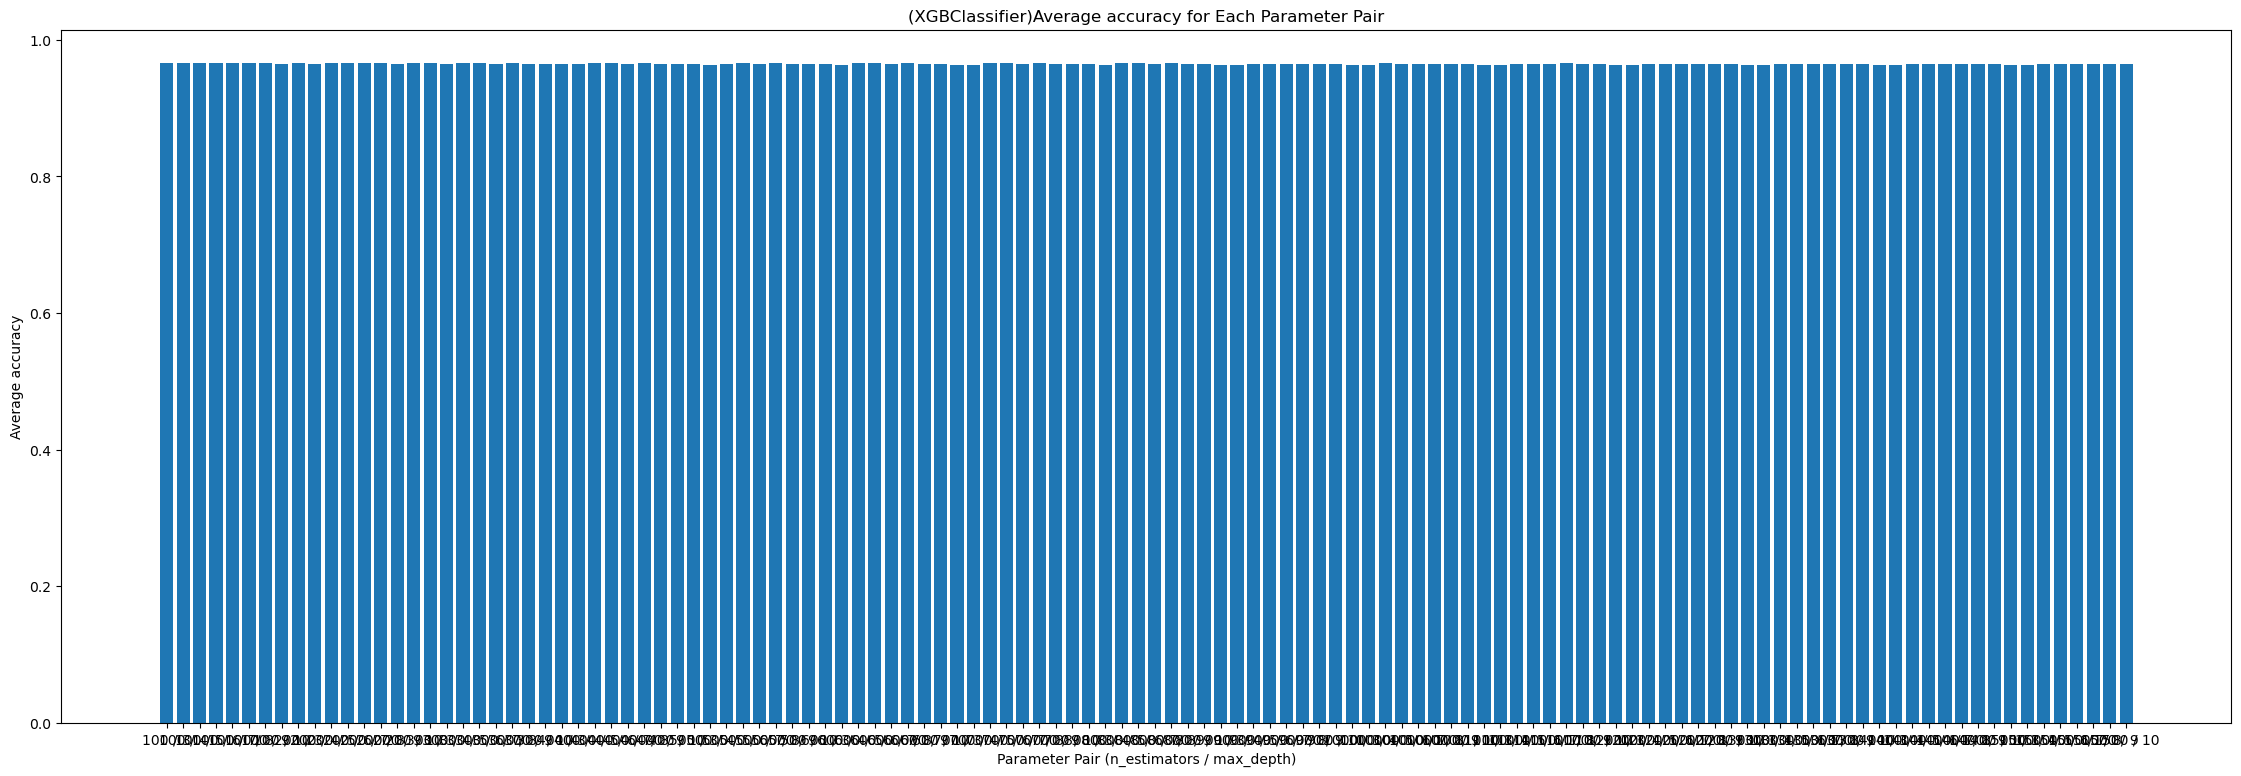

In [3]:
# Aggregate accuracy values for each (n_estimators, max_depth) pair
accuracy_aggregate = {}

for entry in model_performance:
    key = (entry['n_estimators'], entry['max_depth'])
    if key not in accuracy_aggregate:
        accuracy_aggregate[key] = []
    accuracy_aggregate[key].append(entry['accuracy'])

# Calculate average accuracy for each pair
average_accuracy = {k: sum(v)/len(v) for k, v in accuracy_aggregate.items()}

# Prepare data for plotting
n_estimators = [k[0] for k in average_accuracy.keys()]
max_depth = [k[1] for k in average_accuracy.keys()]
avg_accuracy = list(average_accuracy.values())

plt.figure(figsize=(28,9))
plt.bar(range(len(avg_accuracy)), avg_accuracy, tick_label=[f"{n} / {d}" for n, d in zip(n_estimators, max_depth)])
plt.xlabel('Parameter Pair (n_estimators / max_depth)')
plt.ylabel('Average accuracy')
plt.title('(XGBClassifier)Average accuracy for Each Parameter Pair')
plt.show()

In [18]:
from collections import defaultdict
grouped_data =defaultdict(list)
for entry in model_performance:
    key = (entry['n_estimators'], entry['max_depth'])
    grouped_data[key].append(entry['accuracy'])

# Step 2: Calculate the average accuracy for each pair
average_accuracy_per_group = {key: sum(accs) / len(accs) for key, accs in grouped_data.items()}

# Step 3: Find the pair with the highest average accuracy
best_pair = max(average_accuracy_per_group, key=average_accuracy_per_group.get)
best_accuracy = average_accuracy_per_group[best_pair]
print(f"The best pair is n_estimators: {best_pair[0]}, max_depth: {best_pair[1]} with an average accuracy of {best_accuracy}")

The best pair is n_estimators: 100, max_depth: 3 with an average accuracy of 0.9668149262499316


In [23]:
best_params = best_pair
print(f"Best parameters: n_estimators={best_params[0]}, max_depth={best_params[1]} with accuracy: {best_accuracy}")

Best parameters: n_estimators=100, max_depth=3 with accuracy: 0.9668149262499316


# Compare differernt loss function's accuracy

In [24]:
envGen = get_train_environment(n_splits=10)
results = []
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

featureNums = range(1, len(X[0]), 10)

featureNumaccuracys = {}


for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    accuracy_scores1 = []
    accuracy_scores2 = []
    print(f"Fold: {fold}")
    class_y_train_fold = [0 if value == 0 else 1 for value in y_train_fold]
    class_y_test_fold = [0 if value == 0 else 1 for value in y_test_fold]
    
    model1 = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1], objective='binary:logistic') #Default
    model1.fit(X_train_fold, class_y_train_fold)
    predictions1 = model1.predict(X_test_fold)  
    
    model2 = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1], objective='binary:hinge')
    model2.fit(X_train_fold, class_y_train_fold)
    predictions2 = model2.predict(X_test_fold)

    accuracy1 = accuracy_score(class_y_test_fold, predictions1)
    accuracy2 = accuracy_score(class_y_test_fold, predictions2)
    accuracy_scores1.append(accuracy1)
    accuracy_scores2.append(accuracy2)
    
print(np.mean(accuracy_scores1))
print(np.mean(accuracy_scores2))

Found cached folds, using those
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
0.9640591966173362
0.9640591966173362


# Find important feature

In [25]:
best_params

(100, 3)

In [29]:
envGen = get_train_environment(n_splits=5)
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

# Initialize variables to track important features num
print(len(X[0]))
featureNums = range(1, len(X[0]), 10)
featureNumaccuracys = {}

# Cross validation folds
for fold, stats, X_train, X_test, y_train, y_test in envGen:
    print(f"Fold: {fold}")
    class_y_train = [0 if value == 0 else 1 for value in y_train]
    class_y_test = [0 if value == 0 else 1 for value in y_test]
    
    model = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1])
    model.fit(X_train, class_y_train)

    # print(model.feature_importances_)
    # make predictions for test data and evaluate
    predictions = model.predict(X_test)
    accuracy = accuracy_score(class_y_test, predictions)
    print("Overall Fold Mean Squared Error: ", accuracy)
    
    thresholds = enumerate(model.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    eps = 0.000001
    lastaccuracy = None
    for featureNum in featureNums:
        selectedFeatures = [i for i, x in thresholds[:featureNum]]
        
        model = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1])
        XT = X_train[:, selectedFeatures]
        model.fit(XT, class_y_train)
        
        predictions = model.predict(X_test[:, selectedFeatures])
        accuracy = accuracy_score(class_y_test, predictions)
        
        if lastaccuracy is not None:
            if np.abs(accuracy - lastaccuracy) < eps:
                print(np.abs(accuracy - lastaccuracy))
                print(accuracy)
                break
            else:
                lastaccuracy = accuracy
        else:
            lastaccuracy = accuracy
        
        if featureNum in featureNumaccuracys:
            featureNumaccuracys[featureNum].append(accuracy)
        else:
            featureNumaccuracys[featureNum] = [accuracy]
        
        print(f"FeatureNum: {featureNum}")
        print("FeatureNum Mean Squared Error: ", accuracy)



Found cached folds, using those
1574
Fold: 0
Overall Fold Mean Squared Error:  0.965662968832541
FeatureNum: 1
FeatureNum Mean Squared Error:  0.9276281035393555
FeatureNum: 11
FeatureNum Mean Squared Error:  0.9619651347068146
FeatureNum: 21
FeatureNum Mean Squared Error:  0.9614368726888537
FeatureNum: 31
FeatureNum Mean Squared Error:  0.9646064447966192
0.0
0.9646064447966192
Fold: 1
Overall Fold Mean Squared Error:  0.96513470681458
FeatureNum: 1
FeatureNum Mean Squared Error:  0.93608029582673
FeatureNum: 11
FeatureNum Mean Squared Error:  0.9582673005810882
FeatureNum: 21
FeatureNum Mean Squared Error:  0.9619651347068146
FeatureNum: 31
FeatureNum Mean Squared Error:  0.9635499207606973
FeatureNum: 41
FeatureNum Mean Squared Error:  0.9667194928684627
FeatureNum: 51
FeatureNum Mean Squared Error:  0.9630216587427364
FeatureNum: 61
FeatureNum Mean Squared Error:  0.9619651347068146
FeatureNum: 71
FeatureNum Mean Squared Error:  0.9635499207606973
FeatureNum: 81
FeatureNum Mean Sq

In [32]:
avgFeatureNumaccuracys = {x: np.mean(featureNumaccuracys[x]) for x in featureNumaccuracys}
optimal_FeatureNum = [max(avgFeatureNumaccuracys, key=avgFeatureNumaccuracys.get),avgFeatureNumaccuracys[max(avgFeatureNumaccuracys, key=avgFeatureNumaccuracys.get)]]
print("Optimal # of features: ",optimal_FeatureNum[0],", accuracy: ",optimal_FeatureNum[1])

Optimal # of features:  111 , accuracy:  0.9682875264270613


Text(0.5, 1.0, 'XGBoost Classifier feature number vs accuracy')

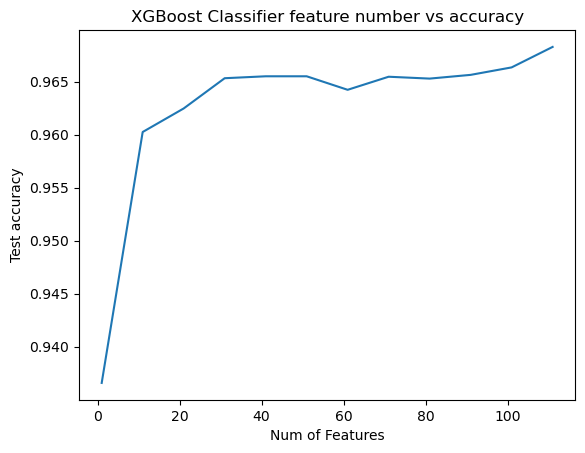

In [33]:
ax = sns.lineplot(pd.Series(avgFeatureNumaccuracys))
ax.set_xlabel("Num of Features")
ax.set_ylabel("Test accuracy")
ax.set_title("XGBoost Classifier feature number vs accuracy")

# Create final model after tuning & select important features

In [34]:
envGen = get_train_environment(n_splits=50)
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

final_accuracys = []
final_selection_intersection = set()
allSelecteds = []

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    class_y_train = [0 if value == 0 else 1 for value in y_train_fold]
    class_y_test = [0 if value == 0 else 1 for value in y_test_fold]
    
    model = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1])
    model.fit(X_train_fold, class_y_train)

    print(model.feature_importances_)
    # make predictions for test data and evaluate
    pre_predictions = model.predict(X_test_fold)

    pre_accuracy = accuracy_score(class_y_test, pre_predictions)
    print("Pre Selection accuracy: ", pre_accuracy)
    
    thresholds = enumerate(model.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    selectedFeatures = [i for i, x in thresholds[:optimal_FeatureNum[0]]]
    allSelecteds.append(selectedFeatures)
    
    if len(final_selection_intersection) == 0:
        final_selection_intersection = final_selection_intersection.union(selectedFeatures)
    else:
        final_selection_intersection = final_selection_intersection.intersection(selectedFeatures)
    
    model = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1])
    
    XT = X_train_fold[:, selectedFeatures]
    model.fit(XT, class_y_train)

    post_predictions = model.predict(X_test_fold[:, selectedFeatures])
    post_accuracy = accuracy_score(class_y_test, post_predictions)
    print("Post Selection accuracy: ", post_accuracy)
    final_accuracys.append(post_accuracy)

Found cached folds, using those
Fold: 0
[0.00939279 0.01190593 0.         ... 0.00292549 0.00288426 0.00272017]
Pre Selection accuracy:  0.9789473684210527
Post Selection accuracy:  0.9789473684210527
Fold: 1
[0.00987883 0.01518001 0.00589713 ... 0.00511763 0.00257535 0.00470528]
Pre Selection accuracy:  0.968421052631579
Post Selection accuracy:  0.968421052631579
Fold: 2
[0.00828828 0.01171904 0.         ... 0.00678737 0.00517824 0.00358642]
Pre Selection accuracy:  0.9578947368421052
Post Selection accuracy:  0.9578947368421052
Fold: 3
[0.00869461 0.01026467 0.         ... 0.00478556 0.00259734 0.00376961]
Pre Selection accuracy:  0.968421052631579
Post Selection accuracy:  0.9578947368421052
Fold: 4
[0.00934743 0.01111776 0.         ... 0.00463926 0.00385495 0.00425189]
Pre Selection accuracy:  0.9631578947368421
Post Selection accuracy:  0.968421052631579
Fold: 5
[0.00873743 0.00893722 0.         ... 0.00759084 0.00336779 0.00340209]
Pre Selection accuracy:  0.9473684210526315
Pos

In [35]:
print(np.mean(final_accuracys))

0.9668192703982177


In [36]:
def feature_labels(features):
    data = pd.read_csv("FinalData.csv")
    data = data.drop(["Name", "appid", 'ln.pricep1', "Unnamed: 0"], axis=1)
    data_columns = data.columns.tolist()
    return [x for i, x in enumerate(data_columns) if i in features]

In [37]:
xgb_class_final_features = feature_labels(final_selection_intersection)

In [38]:
xgb_class_final_features

['release_date',
 'Single-player',
 'Shared/Split Screen Co-op',
 'Steam Achievements',
 'Steam Trading Cards',
 'Captions available',
 'Steam Workshop',
 'Steam Cloud',
 'Remote Play on TV',
 'Remote Play Together',
 'tag_Puzzle',
 'genre_Action',
 'genre_Simulation',
 'tag_Multiplayer',
 'Partial Controller Support',
 'Profile Features Limited',
 'tag_Cute',
 'tag_Memes',
 'tag_Simulation',
 'tag_Open World',
 'genre_Early Access',
 'tag_Card Game',
 'tag_Visual Novel',
 'tag_Casual',
 'tag_Dating Sim',
 'tag_Free to Play',
 'In-App Purchases',
 'tag_Tower Defense',
 'tag_Survival Horror',
 'tag_Psychological Horror',
 'tag_Lovecraftian',
 'tag_Arcade',
 'tag_Idler',
 'tag_Military',
 'tag_Turn-Based Strategy',
 'tag_Word Game',
 'genre_Massively Multiplayer',
 'genre_Sports',
 'pub_tinyBuild',
 'tag_PvP',
 'pub_PlayWay S.A.',
 'MMO',
 'tag_Social Deduction',
 'naccus',
 'esrb_e',
 'esrb_t',
 'ln.Pos_Reviews',
 'ln.dlcp1',
 'ln.curatorsp1',
 'ln.steam_achievementsp1',
 'ln.totDLCPric